In [1]:
import numpy as np
from tqdm import tqdm
import time
import math

# Finite Configurational Approach

The problem of finding a 'least Hamming map' from the infinite set of all integer numbers to an infinite set of possible binary encodings, which minimizes the total hamming distance between subsequent numerical representations, is difficult. To gain a better understanding of the problem, we begin by considering a finite set of possible binary encodings in the following way:

 Given some integer number N corresponding to the number of binary encodings we will need in our problem, create a list of the first N traditional binary numbers. The task now is to find the arrangement of those N bit strings which minimizes the total Hamming distance. 
 
 The hypothesis is that perhas such as solution will be sufficient, or will at least provide useful insight into the problem. I begin by implementing a brute force approach which simply computes the total hamming distance for all N factorial configurations. This algorithm only works somewhat reasonably for N values up to 10 (which takes 5 minutes). It is not scalable since the algorithm is in O(n!) time.

In [2]:
# Takes two binary strings and returns the number of bits that are not equal (ie bit flips to go from one to the other)
def hamming_dist(num1, num2):
    dist = 0
    for i in np.arange(len(num1)):
        if num1[i] != num2[i]:
            dist+=1
    return dist


# sums up the hamming distances between binary numbers in the set
def total_hamming(test_order):
    total = 0
    for i in np.arange(len(test_order)-1):
        total += hamming_dist(test_order[i], test_order[i+1])
    return total


# uses Heap's algorithm to iterate through every permutation of the initial test order
# Takes: n(int) - number of bitstrings in the set, 
#        test_order (list) - current order of the bitstrings (init. default order), 
#        best_order (list) - order w/ lowest total hamming (init. default order)
# Heap's Algorithm takes O(n!) time

def find_best_order(n, test_order, best_order):

    if n == 1: # bottom of the recursive loop. Here test_order should be an independent permutation
        if total_hamming(test_order) < total_hamming(best_order):  # Check if total hamming distance of current ordering is an improvement
            best_order[:] = test_order[:]                           # Update best_order to the current ordering if it is
      
    else:
        for i in range(n):
            find_best_order(n - 1, test_order, best_order)

            # Swap depending on parity of n
            if n % 2 == 0:  # If n is even
                test_order[i], test_order[n - 1] = test_order[n - 1], test_order[i]
            else:  # If n is odd
                test_order[0], test_order[n - 1] = test_order[n - 1], test_order[0]

In [3]:
# n is the number of distinct binary numbers we need
n = 8

max = bin(n)[2:]
max_len = f'0{len(max)}b'

bin_encoding = np.empty(n, dtype=object)

# populate the array with the first n traditional binary numbers
for i in np.arange(n):
    bin_encoding[i] = format(i, max_len)
    print(bin_encoding[i])

0000
0001
0010
0011
0100
0101
0110
0111


In [4]:
# now sort the binary encoding to minimize the total hamming distance (first the brute force way)
# damn... this is like REALLY inneficient 5 min for n=10
# but I think it's right!(?)

test_order = list(bin_encoding)
best_order = test_order[:]
find_best_order(len(test_order), test_order, best_order)
best_hamming = total_hamming(best_order)

print(best_hamming)         #print hamming score optimal config


7


In [5]:
best_order

['0101', '0100', '0000', '0001', '0011', '0010', '0110', '0111']

In [6]:
print(total_hamming(bin_encoding))      #compare to the haming score of the traditional binary encoding

11


#### How can we make this not O(n!) time?... thoughts
- What if we add a condition to throw out a solution as soon as we see that it contains an individual hamming distance of 2 or more?
        --> Here we just have to make sure that we're not missing a good solution where we just need at least one jump
        --> maybe start by throuwing out Hamming distances grater than 2?

- can also break the loop anywhere that the current hamming score is greated than the minimum since that solution is necessarily going to be worse
- need to be careful bc adding extra hamming checks will add (a lot of) computations
        --> save best hamming score in a list defined outside the recursive method to be referenced inside?

# Bit-flip Indexing Approach

Now that we have an implementation of the brute force approach, let's try a completely different, more intelligent approach. After looking at the example calculations Rohan generated by hand (for N=16) with his summation expression, we identified a pattern for which bit is to be flipped to generate the binary encoding of the next integer given the encoding of the previous integer. The pattern for which bit to flip, numbered left to right for N=16 is as follows: 4,3,4,2,4,3,4,1,4,3,4,2,4,3,4.

Further, it turns out that this pattern changes in a predictible way as N increases by powers of 2. To apply this pattern to higher values of $N=2^n$ we need only shift each number up by one, insert a 1 after the string of bit flip indeces, and paste the same pattern again after the 1. This process results in a list of N numbers which dictate which bit to flip to get the binary representation of the following number. (I am inlcined to believe that this algorithm operates in linear time but that remains to be proven/analytically shown). However, we can generate 1,000,000 values in 1.7 seconds so there is plenty of data to be collected on this. The following cells implement this approach.

In [7]:
# Takes the np.array of the indexes upon which to perform a bit flip for N=2^n,
# and returns an np.array of the indexes upon which to perform bit flips for N=2^(n+1)
# NB. we will have to subtract 1 from all the indexes bc I chose to represent the indeces starting at 1 not 0
def get_next_flip_inds(current_flip_inds):
    next_flip_inds = current_flip_inds + 1
    next_flip_inds = np.append(next_flip_inds, 1, axis=None)
    next_flip_inds = np.append(next_flip_inds, next_flip_inds[:-1], axis=None)
    return next_flip_inds

def get_n_flips(flip_inds_init, little_n):
    little_n_init = np.round(np.log2(len(flip_inds_init)))  #rounding bc I got 3.9something initially...

    i = little_n_init
    my_flip_inds = flip_inds_init
    while(i<little_n):
        my_flip_inds = get_next_flip_inds(my_flip_inds)
        i+=1
    return my_flip_inds

In [8]:
#flip_inds_init = np.array([4,3,4,2,4,3,4,1,4,3,4,2,4,3,4])
flip_inds_init = np.array([3,2,3,1,3,2,3])

little_n = 4      #Refers to the power of 2

print(get_n_flips(flip_inds_init=flip_inds_init, little_n=little_n))


[4 3 4 2 4 3 4 1 4 3 4 2 4 3 4]


In [9]:
## Takes: - integer number N of discrete vals we want to represent,
#         - our known bit flip pattern for some lower power of 2 in case we want to change from the 2^4 pattern
#  Returns: the hamming distance 1 binary encodings for integers 0 to N-1
#  Notes: - The function initializes a list with the zero encoding of the appropriate length and loops up to N-1, 
#               generating the next encoding by flipping the appropriate bit as given by the get_n_flips function

#         - Important: I have generalized this to work for non powers of 2 by rounding all powers of 2 UP to the nearest int (math.ceil). ==> For any N != 2^n, the function
#                       is applied to the smallest power of 2 greater than N which will return a list which necessarily includes encodings 1-N

def generate_n_encoding(my_big_N, flip_inds_init):
    string_len = f'0{math.ceil(np.log2(my_big_N))}b'    #NB. I use math.ceil to round up instead of rounding so that for vals of N between powers of 2, 
                                                        #    we generate the encodings for the next power of 2 greater than N
    my_encodings = [format(0, string_len)]                                                              
    flip_inds = get_n_flips(flip_inds_init, math.ceil(np.log2(my_big_N)))

    for i in np.arange(my_big_N-1):
        next_encoding = my_encodings[i]
        current_flip_ind = flip_inds[i]-1           # have to subtract 1 from the indeces since I have chosen flip_inds vals to be between 1 and n
        if next_encoding[current_flip_ind] == '0':            
            next_encoding = next_encoding[:current_flip_ind]+'1'+next_encoding[current_flip_ind+1:]
        else:
            next_encoding = next_encoding[:current_flip_ind]+'0'+next_encoding[current_flip_ind+1:]
        
        my_encodings.append(next_encoding)
    
    return my_encodings
    

In [ ]:
generate_n_encoding(16, flip_inds_init) # running this for 1,000,000 takes about 1.6s

['0000',
 '0001',
 '0011',
 '0010',
 '0110',
 '0111',
 '0101',
 '0100',
 '1100',
 '1101',
 '1111',
 '1110',
 '1010',
 '1011',
 '1001',
 '1000']

# Analysis of Results

We are now able to generate a large number of minimum hamming binary encodings, but we still need to figure out how to actually use these encodings. Rohan raises a good point: even though we guarantee that close integers have small hamming distances in their binary representations, there's nothing to say that some integers that are far apart will not also have small hamming distances. So there are some questions to answer, such as "how much does this matter compared to our original problem of close ints having large hamming dist?" 

One initial thought is that with our encodings we have guaranteed that all adjacent ints have the minimum Hamming distance of one, yielding an average Hamming distance for adjacent ints also equal to one, whereas for integers which are some distance d>1 apart, they cannot also be guaranteed to be Hamming distance 1 apart for all elements. Thus the average Hamming distance for ints separated by d must be greater than 1. Perhaps we might find that as we compute bigger value of N, the occurences of troublesome cases in which very far ints are very close by hamming distance are statistically insignificant. This remains to be seen.

Also, in this analysis, we ought to check for more evidence about the scaling laws of the Bit-Flip Indexing Approach

In [19]:
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [75]:
#computes the time it took to generate N encodings for values from 8 to max_N and returns them in a DataFrame
def get_comp_time_data(max_N):
    results = []

    for big_N in np.arange(8, max_N):
        start = time.perf_counter()
        big_N_encodings = generate_n_encoding(big_N, flip_inds_init)
        end = time.perf_counter()

        results.append([big_N, end-start])

    comp_time_data = pd.DataFrame(results, columns=["big_N", "compute_time"])
    return comp_time_data

In [43]:
enc_scaling_data = get_comp_time_data(2000)

In [44]:
enc_scaling_data.head()

,big_N,compute_time
0,8,0.000148
1,9,0.000125
2,10,0.000082
3,11,0.000075
4,12,0.000082


In [45]:
# Perform a linear fit to the data
model = sm.OLS(enc_scaling_data['compute_time'], enc_scaling_data['big_N'])
result = model.fit()
comp_time_fit = result.fittedvalues
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           compute_time   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                          1.386e+04
Date:                Fri, 20 Dec 2024   Prob (F-statistic):                        0.00
Time:                        22:53:28   Log-Likelihood:                          11407.
No. Observations:                1992   AIC:                                 -2.281e+04
Df Residuals:                    1991   BIC:                                 -2.281e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
big_N       1.799e-06   1.53e-08    117.742      0.000    1.77e-06    1.83e-06
==============================================================================
Omnibus:                      203.795   Durbin-Watson:                   0.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              488.698
Skew:                           0.596   Prob(JB):                    7.59e-107
Kurtosis:                       5.114   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# to see the slop of the fit
result.params

big_N    0.000002
dtype: float64

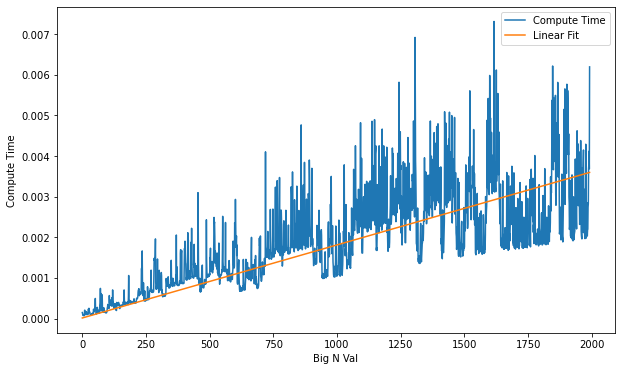

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(enc_scaling_data['compute_time'], label= "Compute Time")
plt.plot(comp_time_fit, label="Linear Fit")
plt.xlabel("Big N Val")
plt.ylabel("Compute Time")
plt.legend()

In [77]:
# given an encoding of N values, and an integer distance int_dist to examine:
# returns a list of the hamming distances between all encodings in the 1-N set whose corresponing integer values are int_dist apart
def d_separated_hammings(int_dist, encoding):
    hammings = []
    for i in np.arange(len(encoding)-int_dist):
        hammings.append(hamming_dist(encoding[i], encoding[i+int_dist]))
    return hammings

In [ ]:
# look at the average hamming distances corresponding to integer distances 0-100 for the first 100 bin encodings
# I can make this into a more general function and loop it over various N vals to see how it behaves w changes in N
# In the end it would be nice to construct a dataframe including the time data and this avg dist data over a range of N values... but im done for the night

encode_100 = generate_n_encoding(100, flip_inds_init)
hamm_distances = []
hamm_avg_per_d = []

for d in np.arange(100):
    current_d_hamms = d_separated_hammings(d, encode_100)
    hamm_distances.append(current_d_hamms)
    current_d_hamm_avg = sum(current_d_hamms)/len(current_d_hamms)
    hamm_avg_per_d.append(current_d_hamm_avg)

In [63]:
hamm_dist_data = pd.DataFrame(hamm_distances)

In [64]:
hamm_dist_data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
3,1,3.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,NaN,NaN,NaN
4,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN


In [ ]:
avg_hamm_data = pd.DataFrame(hamm_avg_per_d)

In [68]:
avg_hamm_data.head(20)

,0
0,0.000000
1,1.000000
2,2.000000
3,1.989691
4,2.000000
5,2.494737
6,2.978723
7,2.483871
8,2.000000
9,2.758242


Text(0, 0.5, 'Average Hamming Distance (range N)')

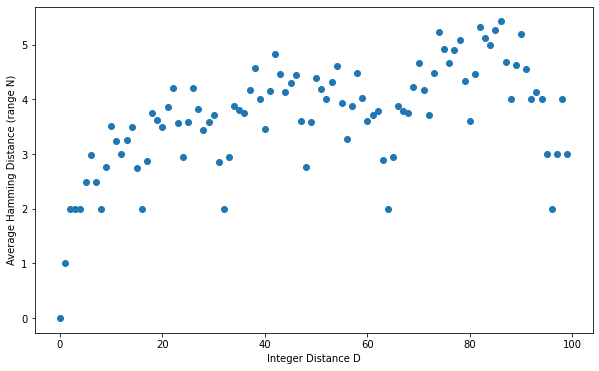

In [74]:
plt.figure(figsize=(10,6))
plt.scatter(x=np.arange(100), y=avg_hamm_data[0])
plt.xlabel("Integer Distance D")
plt.ylabel("Average Hamming Distance (range N)")